In [0]:
%matplotlib inline

In [17]:
!pip install torchsummary
from torchsummary import summary

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Common/')

In [0]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *

In [21]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
BATCH_SIZE = 64
EPOCHS = 30
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)
trainloader = getTrainDataLoader(dataloader_args)
testloader = getTestDataLoader(dataloader_args)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))
optimizer = getOptimizer(model)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,728
             ReLU-10          [-1, 128, 32, 32]               0
   GhostBatchNorm-11          [-1, 128, 32, 32]             256
          Dropout-12          [-1, 128, 32, 32]               0
      

In [22]:
for epoch in range(EPOCHS):
  train(model, device, trainloader, optimizer)
  test.__test(model, device, testloader)

Loss=1.1490215063095093 Batch_id=781 Accuracy=37.59: 100%|██████████| 782/782 [00:22<00:00, 34.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5634, Accuracy: 4241/10000 (42.41%)



Loss=1.2456189393997192 Batch_id=781 Accuracy=54.20: 100%|██████████| 782/782 [00:22<00:00, 34.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3764, Accuracy: 5014/10000 (50.14%)



Loss=0.9521816968917847 Batch_id=781 Accuracy=61.43: 100%|██████████| 782/782 [00:22<00:00, 34.92it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0808, Accuracy: 6177/10000 (61.77%)



Loss=0.9660812616348267 Batch_id=781 Accuracy=65.40: 100%|██████████| 782/782 [00:22<00:00, 34.62it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0729, Accuracy: 6234/10000 (62.34%)



Loss=0.7116634845733643 Batch_id=781 Accuracy=68.72: 100%|██████████| 782/782 [00:22<00:00, 34.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8996, Accuracy: 6821/10000 (68.21%)



Loss=0.826069712638855 Batch_id=781 Accuracy=71.38: 100%|██████████| 782/782 [00:22<00:00, 34.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8602, Accuracy: 6973/10000 (69.73%)



Loss=0.9271616339683533 Batch_id=781 Accuracy=74.03: 100%|██████████| 782/782 [00:22<00:00, 34.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7839, Accuracy: 7234/10000 (72.34%)



Loss=1.3657172918319702 Batch_id=781 Accuracy=75.69: 100%|██████████| 782/782 [00:22<00:00, 34.93it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7378, Accuracy: 7429/10000 (74.29%)



Loss=0.6221750378608704 Batch_id=781 Accuracy=77.50: 100%|██████████| 782/782 [00:22<00:00, 34.60it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6936, Accuracy: 7619/10000 (76.19%)



Loss=0.467701256275177 Batch_id=781 Accuracy=78.31: 100%|██████████| 782/782 [00:22<00:00, 34.86it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7078, Accuracy: 7594/10000 (75.94%)



Loss=0.3988659381866455 Batch_id=781 Accuracy=79.70: 100%|██████████| 782/782 [00:22<00:00, 34.97it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6409, Accuracy: 7788/10000 (77.88%)



Loss=0.2528062164783478 Batch_id=781 Accuracy=80.67: 100%|██████████| 782/782 [00:22<00:00, 35.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6397, Accuracy: 7835/10000 (78.35%)



Loss=1.0496463775634766 Batch_id=781 Accuracy=81.70: 100%|██████████| 782/782 [00:22<00:00, 34.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6237, Accuracy: 7817/10000 (78.17%)



Loss=0.7406376600265503 Batch_id=781 Accuracy=82.48: 100%|██████████| 782/782 [00:22<00:00, 34.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5936, Accuracy: 7995/10000 (79.95%)



Loss=0.5947054028511047 Batch_id=781 Accuracy=83.24: 100%|██████████| 782/782 [00:22<00:00, 35.17it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6410, Accuracy: 7901/10000 (79.01%)



Loss=0.8924838304519653 Batch_id=781 Accuracy=83.71: 100%|██████████| 782/782 [00:22<00:00, 34.95it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5690, Accuracy: 8070/10000 (80.70%)



Loss=0.901074230670929 Batch_id=781 Accuracy=84.54: 100%|██████████| 782/782 [00:22<00:00, 35.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5953, Accuracy: 8037/10000 (80.37%)



Loss=0.4245888888835907 Batch_id=781 Accuracy=84.96: 100%|██████████| 782/782 [00:22<00:00, 35.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5549, Accuracy: 8165/10000 (81.65%)



Loss=0.35223832726478577 Batch_id=781 Accuracy=85.47: 100%|██████████| 782/782 [00:22<00:00, 35.23it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5504, Accuracy: 8125/10000 (81.25%)



Loss=0.7711372971534729 Batch_id=781 Accuracy=86.28: 100%|██████████| 782/782 [00:22<00:00, 35.42it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5750, Accuracy: 8112/10000 (81.12%)



Loss=0.5230792760848999 Batch_id=781 Accuracy=86.74: 100%|██████████| 782/782 [00:22<00:00, 35.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5714, Accuracy: 8126/10000 (81.26%)



Loss=0.22041459381580353 Batch_id=781 Accuracy=87.10: 100%|██████████| 782/782 [00:22<00:00, 35.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5427, Accuracy: 8223/10000 (82.23%)



Loss=0.6011855602264404 Batch_id=781 Accuracy=87.60: 100%|██████████| 782/782 [00:22<00:00, 35.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5600, Accuracy: 8225/10000 (82.25%)



Loss=0.7036598920822144 Batch_id=781 Accuracy=87.89: 100%|██████████| 782/782 [00:22<00:00, 35.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5423, Accuracy: 8243/10000 (82.43%)



Loss=0.438886433839798 Batch_id=781 Accuracy=88.55: 100%|██████████| 782/782 [00:22<00:00, 35.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5755, Accuracy: 8169/10000 (81.69%)



Loss=0.9067937135696411 Batch_id=781 Accuracy=88.66: 100%|██████████| 782/782 [00:22<00:00, 34.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5370, Accuracy: 8304/10000 (83.04%)



Loss=0.6521932482719421 Batch_id=781 Accuracy=89.00: 100%|██████████| 782/782 [00:22<00:00, 34.85it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5606, Accuracy: 8221/10000 (82.21%)



Loss=0.29732847213745117 Batch_id=781 Accuracy=89.28: 100%|██████████| 782/782 [00:22<00:00, 34.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5442, Accuracy: 8301/10000 (83.01%)



Loss=0.21359911561012268 Batch_id=781 Accuracy=89.48: 100%|██████████| 782/782 [00:22<00:00, 34.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5438, Accuracy: 8314/10000 (83.14%)



Loss=0.4631074070930481 Batch_id=781 Accuracy=90.20: 100%|██████████| 782/782 [00:22<00:00, 34.79it/s]



Test set: Average loss: 0.5336, Accuracy: 8344/10000 (83.44%)



In [23]:
!mkdir savedModels
torch.save(model.state_dict(), "./savedModels/cifar.pt")

mkdir: cannot create directory ‘savedModels’: File exists


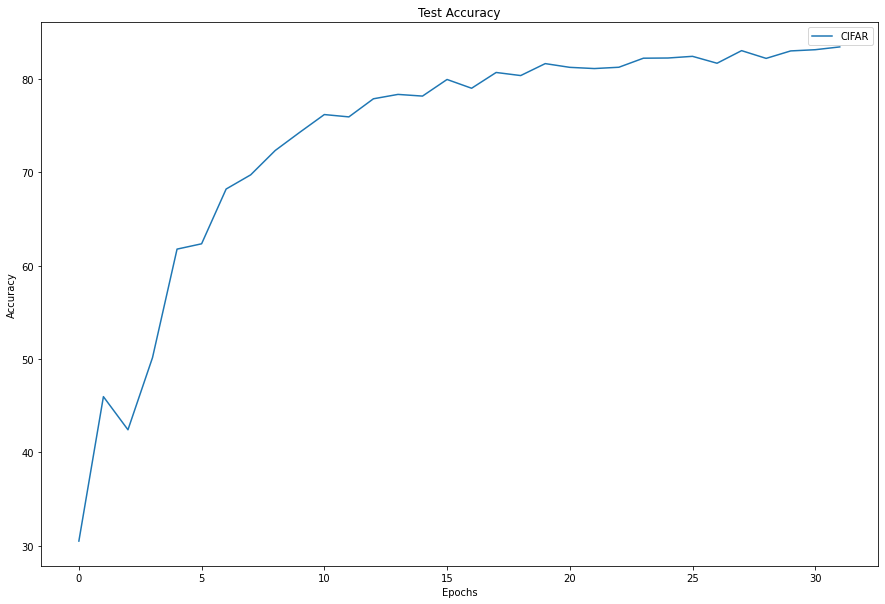

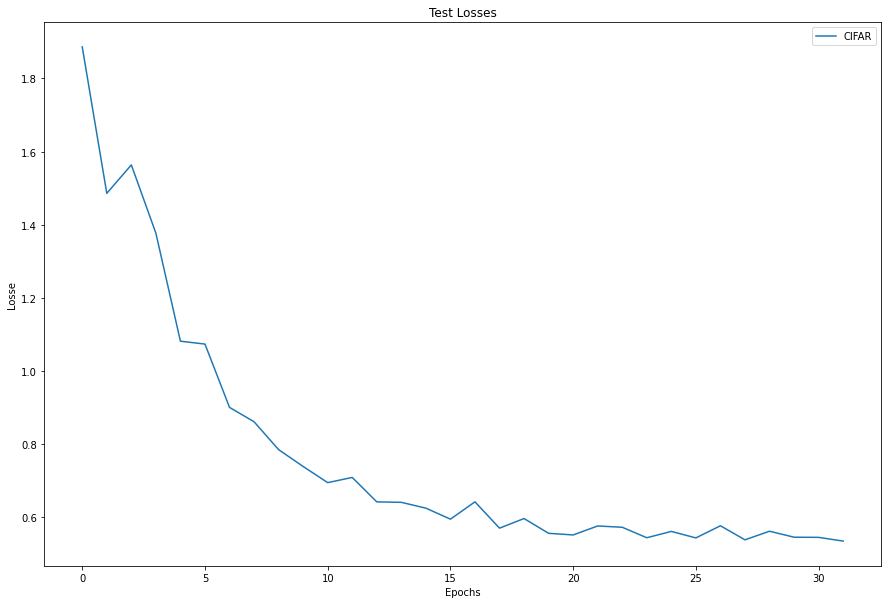

In [24]:
all_test_acc = {'CIFAR':test.test_acc}
plotGraph(all_test_acc, "Test Accuracy","Epochs", "Accuracy")
all_test_loss = {'CIFAR':test.test_losses}
plotGraph(all_test_loss, "Test Losses","Epochs", "Losse")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

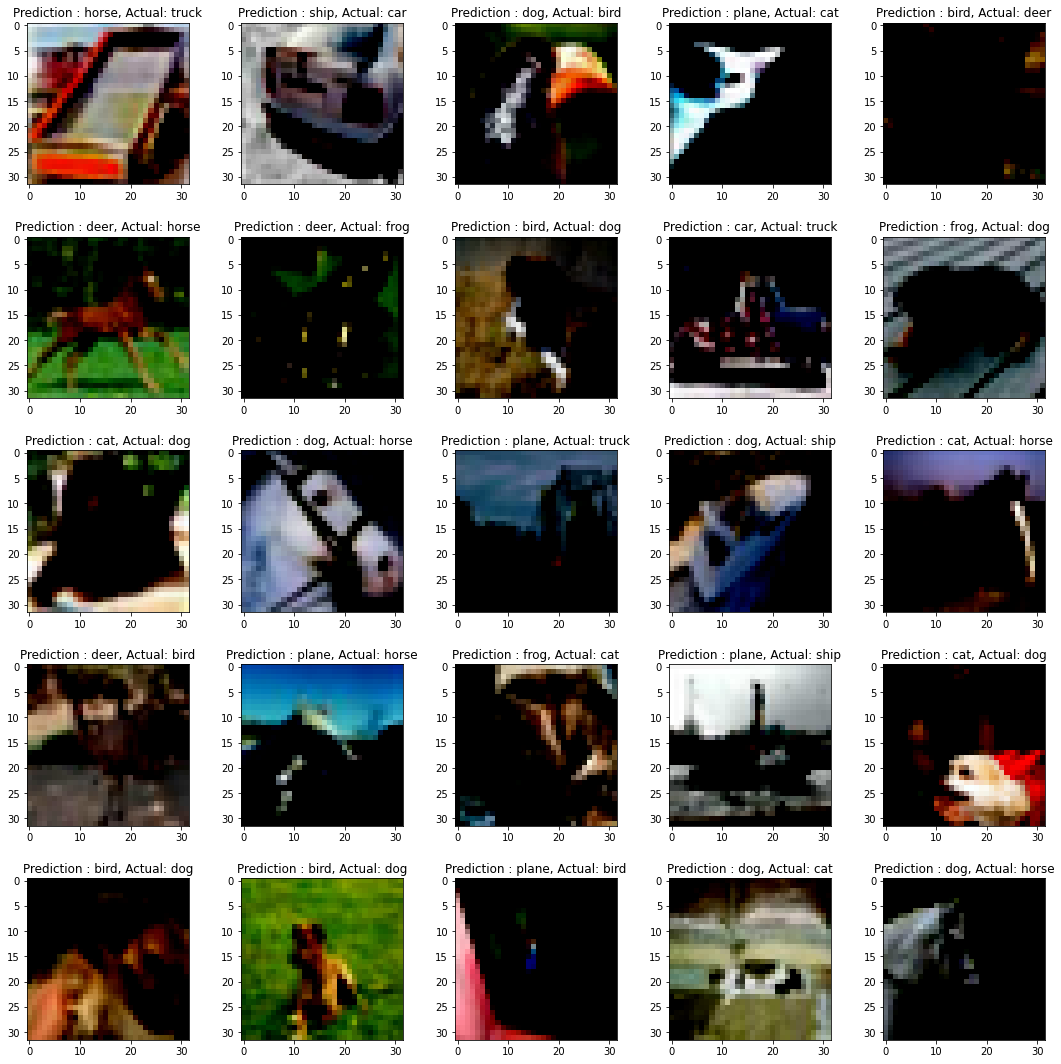

In [25]:
getMisclassifiedImages(Net(), testloader, device, 'savedModels/cifar.pt', classes)